# Embeddings

An embedding maps discrete, categorical values to a continous space. Major advances in NLP applications have come from these continuous representations of words.

If we have some sentence,

In [2]:
!pip install pymagnitude pytorch_pretrained_bert tensorboardcolab -q

In [4]:
# run this once before the next box and once after that to prevent error on the next box
from spacy.lang.en import English

In [5]:
from pymagnitude import Magnitude

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
# from pymagnitude import Magnitude
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from scipy import spatial
from sklearn.manifold import TSNE
# from tensorboardcolab import TensorBoardColab
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook as tqdm


%config InlineBackend.figure_format = 'svg'
%matplotlib inline

RED, BLUE = '#FF4136', '#0074D9'

In [7]:
import tensorboard

In [8]:
sentence = 'the quick brown fox jumps over the lazy dog'
words = sentence.split()
words

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

We first turn this sentence into numbers by assigning each unique word an integer.

In [9]:
word2idx = {word: idx for idx, word in enumerate(sorted(set(words)))} # set ignores duplicates
word2idx

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jumps': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

Then, we turn each word in our sentence into its assigned index.

In [10]:
idxs = torch.LongTensor([word2idx[word] for word in sentence.split()])
idxs

tensor([7, 6, 0, 2, 3, 5, 7, 4, 1])

Next, we want to create an **embedding layer**. The embedding layer is a 2-D matrix of shape `(n_vocab x embedding_dimension)`. If we apply our input list of indices to the embedding layer, each value in the input list of indices maps to that specific row of the embedding layer matrix. The output shape after applying the input list of indices to the embedding layer is another 2-D matrix of shape `(n_words x embedding_dimension)`.

In [11]:
embedding_layer = nn.Embedding(num_embeddings=len(word2idx), embedding_dim=3)
embeddings = embedding_layer(idxs)
embeddings, embeddings.shape

(tensor([[ 0.0065,  1.3557, -0.8453],
         [-0.4100,  1.1935, -0.3777],
         [-0.4381, -0.9800, -0.6474],
         [-0.8135, -0.2797,  1.3131],
         [-0.1514, -2.1715, -0.0048],
         [-1.7385,  0.3449,  1.3353],
         [ 0.0065,  1.3557, -0.8453],
         [-0.7262,  1.6529, -0.2146],
         [ 0.6871, -0.1123, -0.3328]], grad_fn=<EmbeddingBackward0>),
 torch.Size([9, 3]))

The PyTorch builtin embedding layer comes with randomly initialized weights that are updated with gradient descent as your model learns to map input indices to some kind of output. However, often it is better to use pretrained embeddings that do not update but instead are frozen.

## GloVe Embeddings

GloVe embeddings are one of the most popular pretrained word embeddings in use. You can download them [here](https://nlp.stanford.edu/projects/glove/). For the best performance for most applications, I recommend using their Common Crawl embeddings with 840B tokens; however, they take the longest to download, so instead let's download the Wikipedia embeddings with 6B tokens

In [12]:
#Download GloVe vectors (uncomment the below)

# !wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip && mkdir glove && mv glove*.txt glove

GLOVE_address = 'local dataset/glove.6B.50d.txt'
glove_index = {}
n_lines = sum(1 for line in open(GLOVE_address, encoding="utf8"))
with open(GLOVE_address, encoding="utf8") as fp:
    for line in tqdm(fp, total=n_lines):
        split = line.split()
        word = split[0]
        vector = np.array(split[1:]).astype(float)
        glove_index[word] = vector
        
glove_embeddings = np.array([glove_index[word] for word in words])

# Because the length of the input sequence is 9 words and the embedding
# dimension is 50, the output shape is `(9 x 50)`.
glove_embeddings.shape #shape is (9,50) because the input sentence has 9 words

/tmp/ipykernel_6355/2575195553.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm(fp, total=n_lines):


  0%|          | 0/400001 [00:00<?, ?it/s]

(9, 50)

### Magnitude Library for Fast Vector Loading

Loading the entire GloVe file can take up a lot of memory. We can use the `magnitude` library for more efficient embedding vector loading. You can download the magnitude version of GloVe embeddings [here](https://github.com/plasticityai/magnitude#pre-converted-magnitude-formats-of-popular-embeddings-models).

In [ ]:
!wget http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude glove/

In [13]:
# Load Magnitude GloVe vectors
glove_vectors = Magnitude('local dataset/glove.6B.50d.magnitude')

In [14]:
glove_embeddings = glove_vectors.query(words) #query gives the vector map of each word

In [15]:
print(len(glove_vectors) ,glove_vectors.dim)

400000 50


In [16]:
glove_vectors.most_similar(positive = ["woman", "king"], negative = ["man"])

[('queen', 0.85236025),
 ('throne', 0.76643336),
 ('prince', 0.75921446),
 ('daughter', 0.7473882),
 ('elizabeth', 0.74602205),
 ('princess', 0.742457),
 ('kingdom', 0.73374116),
 ('monarch', 0.72144914),
 ('eldest', 0.71848613),
 ('widow', 0.7099431)]

## Similarity operations on embeddings

In [17]:
def cosine_similarity(word1, word2):
    vector1, vector2 = glove_vectors.query(word1), glove_vectors.query(word2) #query gives the vector map of each word
    return 1 - spatial.distance.cosine(vector1, vector2)

In [18]:
word_pairs = [
    ('dog', 'cat'),
    ('tree', 'cat'),
    ('tree', 'leaf'),
    ('king', 'queen'),
]

for word1, word2 in word_pairs:
    print(f'Similarity between "{word1}" and "{word2}":\t{cosine_similarity(word1, word2):.2f}')

Similarity between "dog" and "cat":	0.92
Similarity between "tree" and "cat":	0.57
Similarity between "tree" and "leaf":	0.74
Similarity between "king" and "queen":	0.78


## Visualizing Embeddings

We can demonstrate that embeddings carry semantic information by plotting them. However, because our embeddings are more than three dimensions, they are impossible to visualize. Therefore, we can use an algorithm called t-SNE to project the word embeddings to a lower dimension in order to plot them in 2-D.

In [19]:
ANIMALS = [
    'whale',
    'fish',
    'horse',
    'rabbit',
    'sheep',
    'lion',
    'dog',
    'cat',
    'tiger',
    'hamster',
    'pig',
    'goat',
    'lizard',
    'elephant',
    'giraffe',
    'hippo',
    'zebra',
]

HOUSEHOLD_OBJECTS = [
    'stapler',
    'screw',
    'nail',
    'tv',
    'dresser',
    'keyboard',
    'hairdryer',
    'couch',
    'sofa',
    'lamp',
    'chair',
    'desk',
    'pen',
    'pencil',
    'table',
    'sock',
    'floor',
    'wall',
]

In [20]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS))
tsne_words_embedded.shape

/home/majid/.local/share/virtualenvs/Text_Analysis-46C1vDtS/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/majid/.local/share/virtualenvs/Text_Analysis-46C1vDtS/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(35, 2)

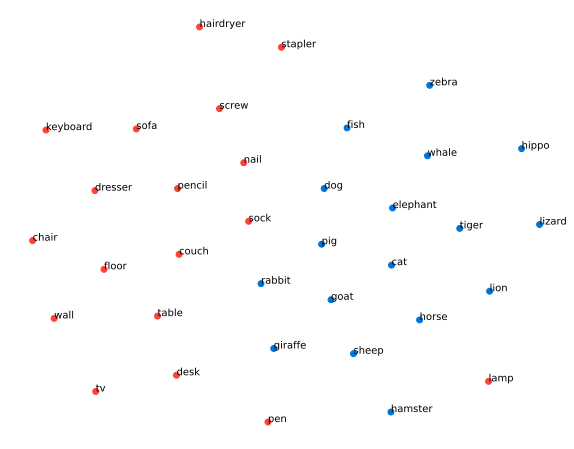

In [21]:
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(10, 8))

for i, label in enumerate(ANIMALS + HOUSEHOLD_OBJECTS):
    if label in ANIMALS:
        color = BLUE
    elif label in HOUSEHOLD_OBJECTS:
        color = RED
        
    ax.scatter(x[i], y[i], c=color)
    ax.annotate(label, (x[i], y[i]))

ax.axis('off')

plt.show()

#### 3D visualization in TensorBoard

In [22]:
# tbc=tensorboard()

vectors = glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS)
with SummaryWriter(log_dir="Graph/") as writer:
    writer.add_embedding(mat=vectors, metadata=ANIMALS+HOUSEHOLD_OBJECTS)

In [23]:
import tensorflow as tf
vectors = glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS)
tf.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
writer = SummaryWriter()
writer.add_embedding(mat=vectors, metadata=ANIMALS+HOUSEHOLD_OBJECTS)


ModuleNotFoundError: No module named 'tensorflow'

In [24]:
%load_ext tensorboard
%tensorboard --logdir=runs/Mar26_23-12-35_DESKTOP-ETB424Q/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Context embeddings

GloVe and Fasttext are two examples of global embeddings, where the embeddings don't change even though the "sense" of the word might change given the context. This can be a problem for cases such as:

- A **mouse** stole some cheese.
- I bought a new **mouse** the other day for my computer.

The word mouse can mean both an animal and a computer accessory depending on the context, yet for GloVe they would receive the same exact distributed representation. We can combat this by taking into account the surroudning words to create a context-sensitive embedding. Context embeddings such as Bert are really popular right now.



In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [28]:
def to_bert_embeddings(text, return_tokens=False):
    if isinstance(text, list):
        # Already tokenized
        tokens = tokenizer.tokenize(' '.join(text))
    else:
        # Need to tokenize
        tokens = tokenizer.tokenize(text)
        
    tokens_with_tags = ['[CLS]'] + tokens + ['[SEP]'] #CLS: class  SEP: separator (to know if the next sentence has begun)
    #output : ['[CLS]', 'i', 'saw', 'a', 'mouse', 'run', 'off', 'with', 'some', 'cheese', '.', '[SEP]']
    indices = tokenizer.convert_tokens_to_ids(tokens_with_tags)
    #output : [101, 1045, 2387, 1037, 8000, 2448, 2125, 2007, 2070, 8808, 1012, 102]
    out = model(torch.LongTensor(indices).unsqueeze(0))
    # Concatenate the last four layers and use that as the embedding
    # bert has 12 layers and it seems the model output gives us the output of all layers
    # also this model gives us another output whcih is the output the classifier 
    # source: https://jalammar.github.io/illustrated-bert/
    embeddings_matrix = torch.stack(out[0]).squeeze(1)[-4:]  # use last 4 layers
    # embeddings_matrix.shape = (4,n,768) : [layers, number of words(cls and sep included), embeddings shape]
    embeddings = []
    for j in range(embeddings_matrix.shape[1]):
        embeddings.append(embeddings_matrix[:, j, :].flatten().detach().numpy())     
    
    # embeddings shape : [number of words, 3072]
    # Ignore [CLS] and [SEP]
    embeddings = embeddings[1:-1]
        
    if return_tokens:
        assert len(embeddings) == len(tokens)
        return embeddings, tokens
    
    return embeddings

In [29]:
words_sentences = [
    ('mouse', 'I saw a mouse run off with some cheese.'),
    ('mouse', 'I bought a new computer mouse yesterday.'),
    ('cat', 'My cat jumped on the bed.'),
    ('keyboard', 'My computer keyboard broke when I spilled juice on it.'),
    ('dessert', 'I had a banana fudge sunday for dessert.'),
    ('dinner', 'What did you eat for dinner?'),
    ('lunch', 'Yesterday I had a bacon lettuce tomato sandwich for lunch. It was tasty!'),
    ('computer', 'My computer broke after the motherdrive was overloaded.'),
    ('program', 'I like to program in Java and Python.'),
    ('pasta', 'I like to put tomatoes and cheese in my pasta.'),
]
words = [words_sentence[0] for words_sentence in words_sentences]
sentences = [words_sentence[1] for words_sentence in words_sentences]

In [30]:
embeddings_lst, tokens_lst = zip(*[to_bert_embeddings(sentence, return_tokens=True) for sentence in sentences])
words, tokens_lst, embeddings_lst = zip(*[(word, tokens, embeddings) for word, tokens, embeddings in zip(words, tokens_lst, embeddings_lst) if word in tokens])

# Convert tuples to lists
words, tokens_lst, tokens_lst = map(list, [words, tokens_lst, tokens_lst])

In [31]:
# finding the position of each key word in the sentence
target_indices = [tokens.index(word) for word, tokens in zip(words, tokens_lst)] 

In [32]:
target_embeddings = [embeddings[idx] for idx, embeddings in zip(target_indices, embeddings_lst)]

/home/majid/.local/share/virtualenvs/Text_Analysis-46C1vDtS/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/majid/.local/share/virtualenvs/Text_Analysis-46C1vDtS/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


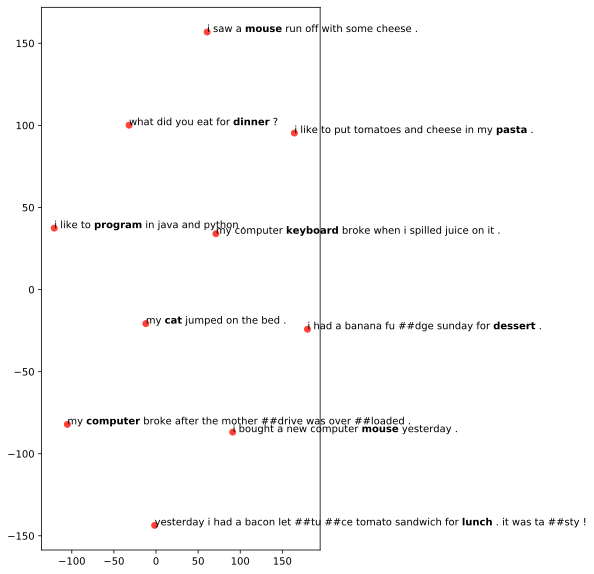

In [33]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(target_embeddings)
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(5, 10))

for word, tokens, x_i, y_i in zip(words, tokens_lst, x, y):
    ax.scatter(x_i, y_i, c=RED)
    ax.annotate(' '.join([f'$\\bf{x}$' if x == word else x for x in tokens]), (x_i, y_i))

# ax.axis('off')
plt.show()

## Fasttext

- Use the Magnitude library to load other pretrained embeddings such as Fasttext
- Try comparing the GloVe embeddings with the Fasttext embeddings by making t-SNE plots of both, or checking the similarity scores between the same set of words
- Make t-SNE plots using your own words and categories